# Stochastic volatility
This notebook demos how to construct a stochastic volatility model and fit it to data. We'll use the Verhulst model for the volatility process, s.t.

\begin{cases}
    Y_t = \mu + V_t W_t, \\
    dV_t = \kappa V_t (\gamma - V_t)dt + \sigma V_t dU_t, \\
\end{cases}

where $\mu, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$. $\{U_t\}$ is a Brownian motion, wheras $\{W_t\}$ is assumed to follow a [Sinh-Arcsinh distribution](https://www.r-bloggers.com/2019/04/the-sinh-arcsinh-normal-distribution/) utilizing a standard normal as base distribution, where the transform is parameterized by $\nu \in \mathbb{R}$, and $\tau \in \mathbb{R}_+$. 

Next, we shall define our model in code. In order to do so, we must specify priors for the different parameters. Given their support, we assume that

\begin{cases}
    \kappa \sim \mathcal{E}(10), \\    
    \gamma \sim \mathcal{LN}(0, 1), \\    
    \sigma \sim \mathcal{LN}(-2, 0.5), \\
    \mu \sim \mathcal{N}(0, 0.5), \\
    \nu \sim \mathcal{N}(0, 0.15), \\
    \tau \sim \mathcal{LN}(0, 0.1).
\end{cases}

Setting a discretization step of $\Delta t = 0.2$ and 5 integration steps we get the following model

In [1]:
from pyfilter import inference as inf, filters as filts, __version__
from stochproc import timeseries as ts, __version__ as sp_version, distributions as dists
from pyro.distributions import LogNormal, Exponential, Gamma, SkewLogistic, Normal, transforms, TransformedDistribution
from torch.distributions import Distribution
from math import log
import torch


print(f"stoch-proc: {sp_version}")
print(f"pyfilter: {__version__}")
print(torch.cuda.get_device_name())


def build_obs(x, mean, skew, kurt):
    scale = x.value

    sinh_arcsinh = dists.SinhArcsinhTransform(skew, kurt)
    affine_transform = transforms.AffineTransform(mean, scale)

    normal = Normal(torch.zeros_like(scale), torch.ones_like(scale))

    return TransformedDistribution(normal, [sinh_arcsinh, affine_transform])


def build_model(context: inf.InferenceContext):
    kappa = context.named_parameter("kappa", Exponential(10.0).cuda())
    gamma = context.named_parameter("gamma", LogNormal(0.0, 1.0).cuda())
    sigma = context.named_parameter("sigma", LogNormal(log(0.05), 1.0).cuda())

    dt = 0.2
    vol = ts.models.Verhulst(kappa, gamma, sigma, dt=dt)
    
    mu = context.named_parameter("mu", Normal(0.0, 0.5).cuda())
    nu = context.named_parameter("nu", Normal(0.0, 0.15).cuda())
    tau = context.named_parameter("tau", LogNormal(0.0, 0.1).cuda())
    
    return ts.StateSpaceModel(vol, build_obs, (mu, nu, tau), observe_every_step=int(1.0 / dt))


stoch-proc: 0.3.0
pyfilter: 0.29.0
NVIDIA GeForce RTX 3070


And that defines the model. Next, we need a dataset to train on. We'll use AAPL, masking days where the price hasn't changed to nan

<Axes: xlabel='Date'>

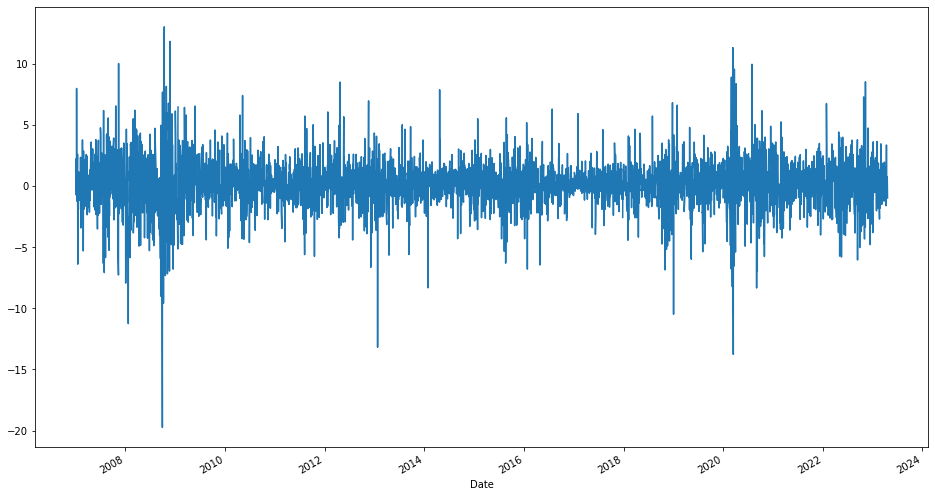

In [8]:
import numpy as np
import pandas as pd
from yfinance import Ticker
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

tick = Ticker("AAPL")
hist = tick.history(start="2007-01-01")

y = np.log(hist["Close"]).diff().iloc[1:] * 100.0
y = y.where(y != 0.0, np.nan)

fig, ax = plt.subplots()
y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use the SMC$^2$ algorithm by Chopin et al. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use the APF.

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import APF, proposals
import torch

predictions = 10
train = y.iloc[:-predictions]

train_tensor = torch.from_numpy(train.values).float().cuda()

results = list()
for i in range(2):
    with inf.make_context(use_quasi=True) as context:
        filt = APF(build_model, 400)
        alg = SMC2(filt, 1_000, num_steps=5, threshold=0.2, distance_threshold=0.025)

        state = alg.fit(train_tensor)

        results.append((context, state))

SMC2: 100%|██████████| 4093/4093 [06:32<00:00, 10.42it/s] 


Next, we plot the posterior distributions for the parameters. We use a custom plotting function since we need to weight the posteriors to get an accurate representation.

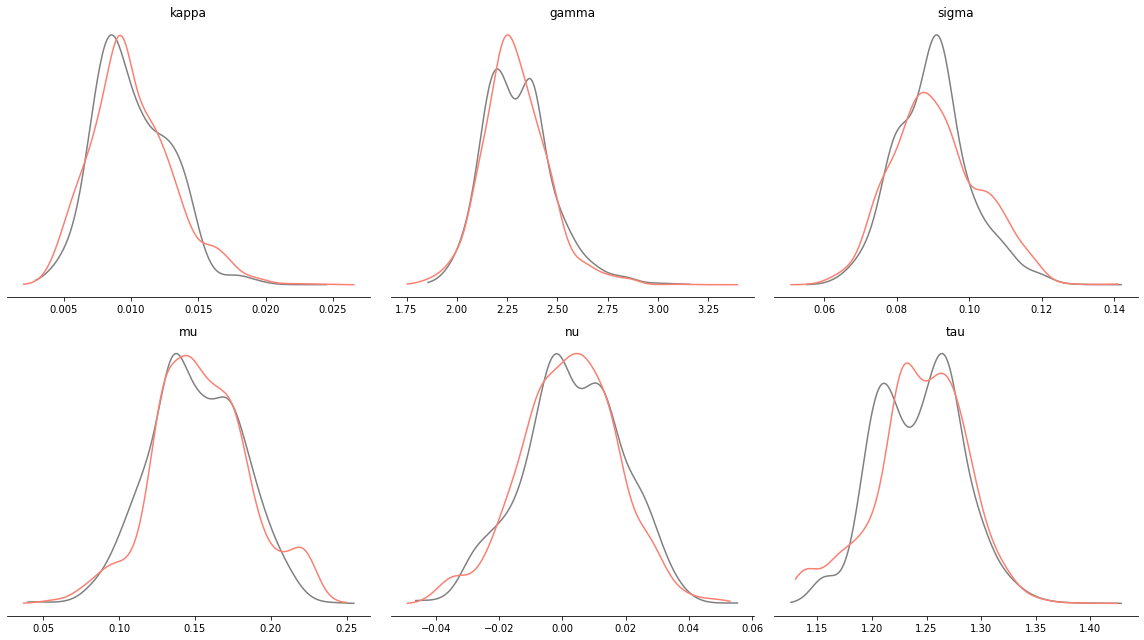

In [9]:
from pyfilter.inference.plot import mimic_arviz_posterior

colors = ["gray", "salmon"]

ax = None
for iteration, (context, state) in enumerate(results):
    ax = mimic_arviz_posterior(context, state, color=colors[iteration], ax=ax)
        
plt.tight_layout()

Let's plot the underlying volatility

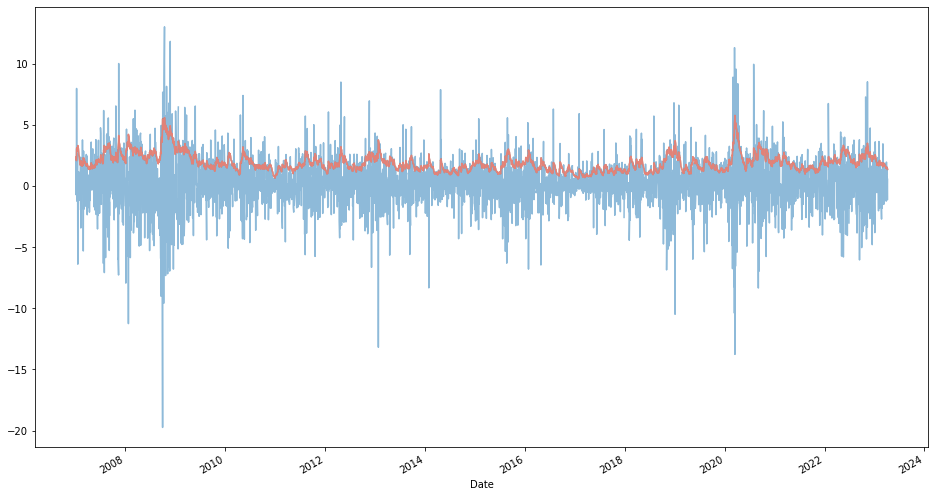

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

train.plot(ax=ax, alpha=0.5)

for iteration, (_, state) in enumerate(results):
    means = state.normalized_weights() @ state.filter_state.filter_means[1:]
    ax.plot(train.index, means.cpu().numpy(), color=colors[iteration], alpha=0.8)

We can clearly see the volatility spikes caused by the 2008 crash and the COVID breakout.

A plot over the ESS.

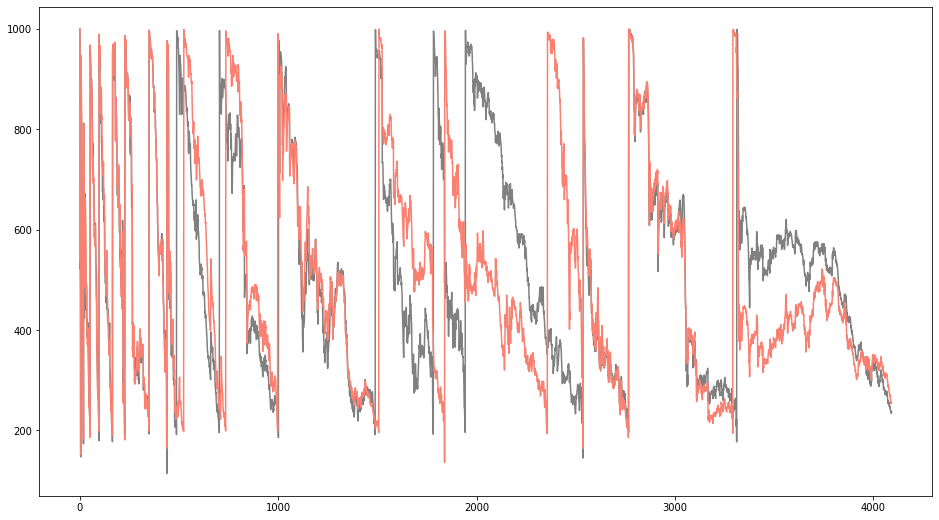

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (_, state) in enumerate(results):
    ax.plot(state.ess.cpu().numpy(), color=colors[i])

And finally get an estimate of the future return distribution

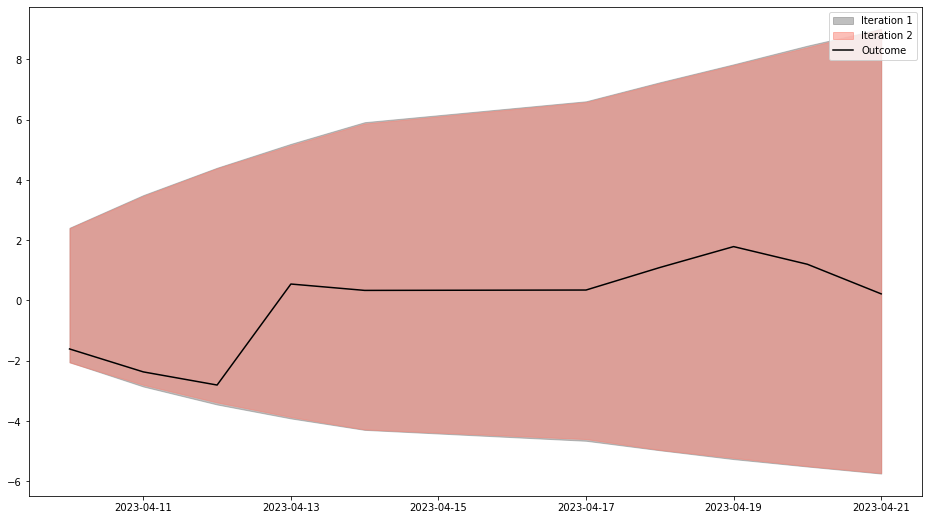

In [7]:
def get_q_index(x, q):
    return (x - q).pow(2.0).argmin(dim=-1).unsqueeze(-1)


fig, ax = plt.subplots(figsize=(16, 9))

quantile = 0.95
outcome = y.iloc[-predictions:].cumsum()

for i, (context, state) in enumerate(results):    
    model = build_model(context)    
    path = state.filter_state.latest_state.predict_path(model, predictions * model.observe_every_step)

    _, y_pred = path.get_paths()
    
    y_pred = y_pred[model.observe_every_step - 1::model.observe_every_step].flatten(1).cumsum(dim=0)
    index = y_pred.argsort(dim=-1)
    y_pred = y_pred.gather(-1, index)
    
    weights = (state.normalized_weights() * state.filter_state.latest_state.normalized_weights())
    cum_weights = weights.ravel().expand_as(y_pred).take_along_dim(index, -1).cumsum(dim=-1)
    
    high_index = get_q_index(cum_weights, quantile)
    low_index = get_q_index(cum_weights, 1.0 - quantile)

    high = y_pred.take_along_dim(high_index, -1).squeeze(-1).cpu()
    low = y_pred.take_along_dim(low_index, -1).squeeze(-1).cpu()
    
    ax.fill_between(outcome.index, low, high, color=colors[i], alpha=0.5, label=f"Iteration {i+1:d}")    
    
ax.plot(outcome, color="black", label="Outcome")
ax.legend()